## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [2]:
pip install odc-geo --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [7]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup
import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster, create_dask_gateway_cluster
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from coastlines.raster import model_tides

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37337 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34437 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/37337/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


## Setup

In [8]:
dc = datacube.Datacube(app='Intertidal_elevation')

In [9]:
aoi = 'Wollogorang'
# aoi = 'McCarthur River'
# aoi = 'Greenbank'
# aoi = 'Seven Emu'

time_range = ('2017', '2021')
resolution = 10

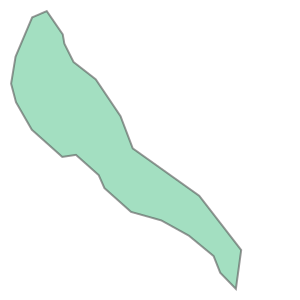

In [10]:
# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [40]:
# geom = Geometry(
#     {
#         "type": "Polygon",
#         "coordinates": (
#             (
#                 (137.79429514807742, -16.33047910594542),
#                 (137.7949378151145, -16.37562560630653),
#                 (137.84170191116758, -16.3749990258955),
#                 (137.84104852619626, -16.32985434676979),
#                 (137.79429514807742, -16.33047910594542),
#             ),
#         ),
#     }
# )

## Virtual product

In [29]:
from datacube.virtual import catalog_from_file

# Load in virtual product catalogue and select MNDWI product
catalog = catalog_from_file('configs/dea_virtual_product_landsat_s2.yaml')

In [30]:
# Create the 'query' dictionary object
query_params = {
    "geopolygon": geom,
    "time": time_range,
    "resolution": (-10, 10),
    "output_crs": "epsg:32753",
    "dask_chunks": {"time": 1, "x": 2048, "y": 2048},
    "resampling": {
        "*": "cubic",
        "oa_nbart_contiguity": "nearest",
        "oa_fmask": "nearest",
        "oa_s2cloudless_mask": "nearest",
    },
}

In [31]:
# Load Sentinel-2 data
product = catalog["s2_nbart_ndwi"]
s2_ds = product.load(dc, **query_params)

# Apply cloud mask and contiguity mask
s2_ds_masked = s2_ds.where(s2_ds.cloud_mask == 1 & s2_ds.contiguity)[['ndwi']]

In [32]:
# Load Landsat data
product = catalog["ls_nbart_ndwi"]
ls_ds = product.load(dc, **query_params)

# Clean cloud mask by applying morphological closing to all 
# valid (non cloud, shadow or nodata) pixels. This removes 
# long, narrow features like false positives over bright beaches.
a = ls_ds.cloud_mask.isin([1, 4, 5])
good_data_cleaned = mask_cleanup(
    mask=a,
    mask_filters=[("closing", 5)],
)

# Dilate cloud and shadow. To ensure that nodata areas (e.g. 
# Landsat 7 SLC off stripes) are not also dilated, only dilate 
# mask pixels (e.g. values 0 in `good_data_cleaned`) that are 
# outside of the original nodata pixels (e.g. not 0 in 
# `ls_ds.cloud_mask`)
b = ((good_data_cleaned == 0) & (ls_ds.cloud_mask != 0))
good_data_mask = mask_cleanup(
    mask=b,
    mask_filters=[("dilation", 5)],
)

# Apply cloud mask and contiguity mask
ls_ds_masked = ls_ds.where(~good_data_mask & ls_ds.contiguity)[['ndwi']]

In [33]:
# Combine into a single ds
ds = xr.concat([s2_ds_masked, ls_ds_masked], dim='time').sortby('time')
ds

<xarray.Dataset>
Dimensions:      (time: 507, y: 501, x: 501)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-21T00:53:13.103994 ... 2021-12...
  * y            (y) float64 8.192e+06 8.192e+06 ... 8.187e+06 8.187e+06
  * x            (x) float64 7.986e+05 7.986e+05 ... 8.036e+05 8.036e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 501, 501), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

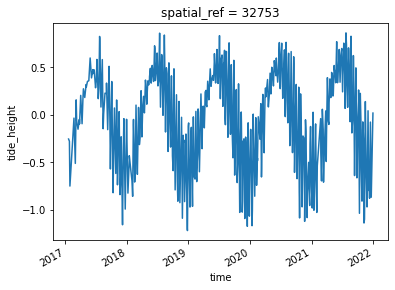

In [34]:
lon, lat = ds.geobox.extent.to_crs('EPSG:4326').centroid.xy
tides_out = model_tides(x=lon, y=lat, time=ds.time, directory='~/tide_models')
ds['tide_height'] = tides_out.tide_m
ds.tide_height.plot()

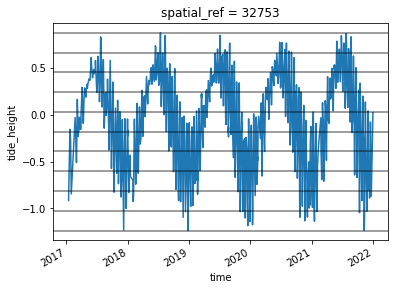

In [17]:
# classes
n = 10

# Sort every image by tide height
ds_clear = ds.sortby('tide_height')

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
binInterval = np.linspace(ds.tide_height.min(),
                          ds.tide_height.max(),
                          num=n+1)
tide_intervals = pd.cut(ds.tide_height,
                        bins=binInterval,
                        labels=range(1, n+1),
                        include_lowest=True)

# Add interval to dataset
ds['tide_interval'] = xr.DataArray(tide_intervals, coords=[ds.time])
ds.sortby('time').tide_height.plot()
for i in binInterval: plt.axhline(i, c='black', alpha=0.5)

In [47]:
# For each interval, compute the median water index and tide height value
ds_intervals = (
    ds[["tide_interval", "ndwi", "tide_height"]]
    .groupby("tide_interval")
    .median(dim="time")
    .compute()
)

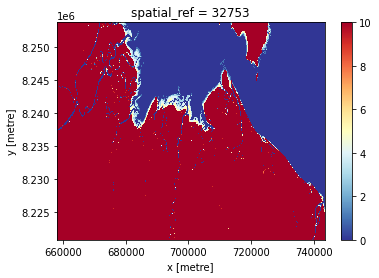

In [48]:
# Plot the resulting set of tidal intervals
item = ((ds_intervals.ndwi < 0) * ds_intervals.tide_interval).max(dim='tide_interval')
item.plot.imshow(cmap='RdYlBu_r')

In [49]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': ds_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=item,
                                 z_values=[i - 0.5 for i in range(1, n + 1)],
                                 crs=ds.crs,
                                 affine=ds.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=2,  #20,
                                 output_path='tide_intervals.geojson',
                                 dim='tide_interval')
# contours_gdf.explore(column='tide_m')

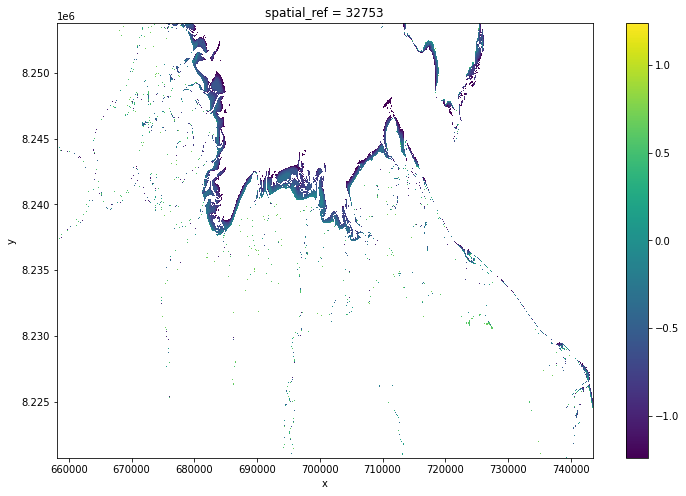

In [50]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=ds_intervals,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2]).astype(np.float32)

# Identify areas that are always wet (e.g. below low tide), or always dry
# above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
# below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# above_lowest = mask_cleanup(above_lowest, mask_filters=[('dilation', 1)])

above_lowest = item > item.min()
below_highest = item < item.max()

# Keep only pixels between high and low tide
intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

# Plot the cleaned dataset
intertidal_dem_clean.plot(cmap='viridis', size=8)
plt.show()

In [51]:
sensor = 's2ls_virtual'
# aoi = 'v1'
f'intertidal_dem_{sensor}_{aoi}.tif'

'intertidal_dem_s2ls_virtual_Greenbank.tif'

In [52]:
# Export as a GeoTIFF
write_cog(geo_im=intertidal_dem_clean, 
          fname=f'data/interim/intertidal_dem_{sensor}_{aoi}.tif', 
          overwrite=True)

PosixPath('data/interim/intertidal_dem_s2ls_virtual_Greenbank.tif')

In [35]:
import folium 

# Create folium Map
m = folium.Map()
intertidal_dem_clean.odc.reproject('epsg:3857', dst_nodata=np.nan).odc.add_to(m, opacity=1.0, vmin=-1.0, vmax=0.5) 
m.fit_bounds(intertidal_dem_clean.odc.map_bounds())
display(m)

## Pixel-based

In [35]:
ds_small = ds[['ndwi', 'tide_height']].compute()

CPLReleaseMutex: Error = 1 (Operation not permitted)


In [42]:
from dea_tools.temporal import lag_linregress_3D

In [160]:
ds_small['NDWI_bool'] = (ds_small.ndwi > 0).where(~ds_small.ndwi.isnull())

In [67]:
out_ds = lag_linregress_3D(ds_small.ndwi.clip(-0.2, 0.2), ds_small.tide_height)

In [114]:
# ds_small.ndwi.isel(time=slice(0, 100)).plot(col='time', col_wrap=5)

In [56]:
# out_ds.intercept.where(out_ds.pval < 0.01).odc.write_cog(fname='test.tif', overwrite=True)

PosixPath('test.tif')

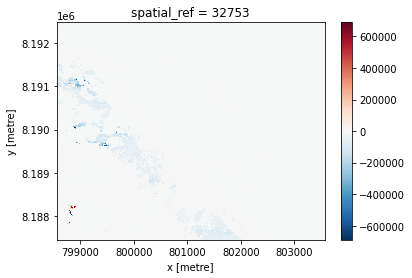

In [68]:
out_ds.intercept.plot()

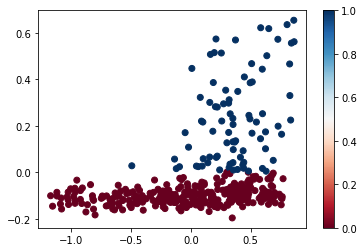

In [236]:
ndwi_array = ds_small.isel(x=150, y=150).sortby('tide_height').ndwi.values
tide_array = ds_small.isel(x=150, y=150).sortby('tide_height').tide_height.values

import pandas as pd
df = pd.DataFrame({'ndwi': ndwi_array, 'tide': tide_array}).dropna()
df['bool'] = (df.ndwi > 0).astype(int)

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('Greys')

sc = ax.scatter(df['tide'], df['ndwi'], c=df['bool'],
                vmin=0, vmax=1, cmap='RdBu')
cb = fig.colorbar(sc)

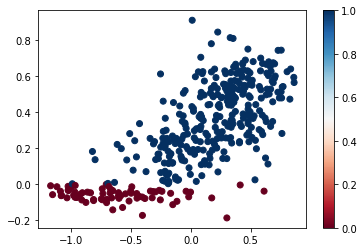

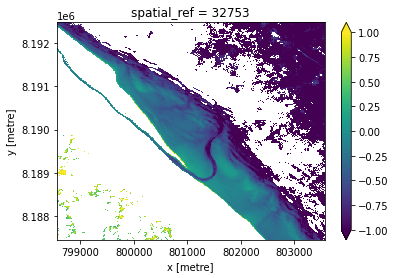

In [73]:
out_ds.intercept.where(out_ds.pval < 0.01).plot(vmin=-1, vmax=1)

## Dask gateway

In [57]:
# with create_dask_gateway_cluster(profile='r5_L', workers=2) as cluster:
#     print('Dashboard', cluster.dashboard_link)
#     client = cluster.get_client()
#     ndwi_median = ds.ndwi.sel(time='2020').median(dim='time').compute()


In [25]:
import dask
dask.__version__

'2.30.0'

In [23]:
import distributed

In [24]:
distributed.__version__

'2.30.0'

In [26]:
import dask_gateway

In [27]:
dask_gateway.__version__

'0.9.0'

In [ ]:
# filter_dict = dict(time=62, 
#                    x=slice(750, 1250), 
#                    y=slice(700, 1200))

# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# ls_ds.isel(filter_dict).ndwi.plot.imshow(ax=axes[0, 0])
# ls_ds.isel(filter_dict).cloud_mask.plot.imshow(ax=axes[0, 1])
# a.isel(filter_dict).plot.imshow(ax=axes[0, 2])
# good_data_cleaned.isel(filter_dict).plot.imshow(ax=axes[1, 0])
# b.isel(filter_dict).plot.imshow(ax=axes[1, 1])
# good_data_mask.isel(filter_dict).plot.imshow(ax=axes[1, 2])

# ls_ds_masked.isel(x=slice(750, 1250), y=slice(700, 1200)).ndwi.median(dim='time').plot.imshow(size=12)